In [1]:
!pip install mllibs

     |████████████████████████████████| 125 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 24.2 MB/s eta 0:00:01
     |████████████████████████████████| 903 kB 31.7 MB/s eta 0:00:01
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pingouin 0.5.4 requires pandas>=1.5, but you'll have pandas 1.1.3 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from IPython.core.display import display, HTML, Javascript

color_map = ['#FFFFFF','#FF5733']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]


In [5]:
import os,sys,warnings
if not sys.warnoptions:    
    warnings.simplefilter('ignore')
    
import numpy as np
from numpy.linalg import pinv,inv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(style='whitegrid')
%matplotlib inline

import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin,ClassifierMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
pi = 4.0*np.arctan(1.0)

color1 = 'darkviolet'
color2 = 'indigo'

In [6]:
# load the dataset
df = pd.read_csv('/kaggle/input/calihouse/housing.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20637 non-null  float64
 3   total_rooms         20635 non-null  float64
 4   total_bedrooms      20429 non-null  float64
 5   population          20628 non-null  float64
 6   households          20630 non-null  float64
 7   median_income       20631 non-null  float64
 8   median_house_value  20632 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [8]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


- `.info()` is perhaps a good starting point, having read & loaded data into a pandas dataframe
- `RangeIndex` tells us the maximum loaded data instane, thus we can quickly identify columns w/ missing data
- `pandas` can read a wide range of data types; so `Dtype` information is very handy to know
- `.head()` is a nice way to peak at our dataset, `.tail` also is a quick way to scroll to the bottom of the dataset

In [9]:
# Let's show all columns with missing data as well:
df[df.isnull().any(axis=1)] # any missing data in columns

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0
532,-122.27,37.78,52.0,1408.0,NaN,718.0,265.0,2.6806,207900.0
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0
...,...,...,...,...,...,...,...,...,...
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0


### <b>Data imputation </b>

- We can note that we have a number of features with some missing data, but not too many instances overall (257/20640);
- Lets try an `Unsupervised Learning (UL)` approach based on the `kNN` model, we can use the function below and pass a dataframe to generated an imputed dataframe

#### **KNN Unsupervised Learning Imputation</span>**
- Function to impuse missing data using an unsupervised model.

In [10]:
from sklearn.neighbors import KNeighborsRegressor

# function that imputes a dataframe 
def impute_knn(df):
    
    ''' inputs: pandas df containing feature matrix '''
    ''' outputs: dataframe with NaN imputed '''
    # imputation with KNN unsupervised method

    # separate dataframe into numerical/categorical
    ldf = df.select_dtypes(include=[np.number])           # select numerical columns in df
    ldf_putaside = df.select_dtypes(exclude=[np.number])  # select categorical columns in df
    # define columns w/ and w/o missing data
    cols_nan = ldf.columns[ldf.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ldf.columns.difference(cols_nan).values     # columns w/o nan 

    for col in cols_nan:                
        imp_test = ldf[ldf[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ldf.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ldf,ldf_putaside],axis=1)

In [11]:
# Call function that imputes missing data
df2 = impute_knn(df)
# looks like we have a full feature matrix
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### <b> 2.3 | Creating a hold-out set</b>

- Thorough of the entire dataset & not having the availability of new data is undesirable. 
- We want to reserve some data, & use it to see how good the model is at prediction on unseen data, so lets create it using `train_test_split` 

`trdata` : Training Data Subset (Let's inspect the data as if we only had this data this)<br>
`tedata` : Test Data Subset (Use this subset for model evaluation)

In [12]:
# 70/30 Split should do
trdata,tedata = train_test_split(df2,test_size=0.3,random_state=43)

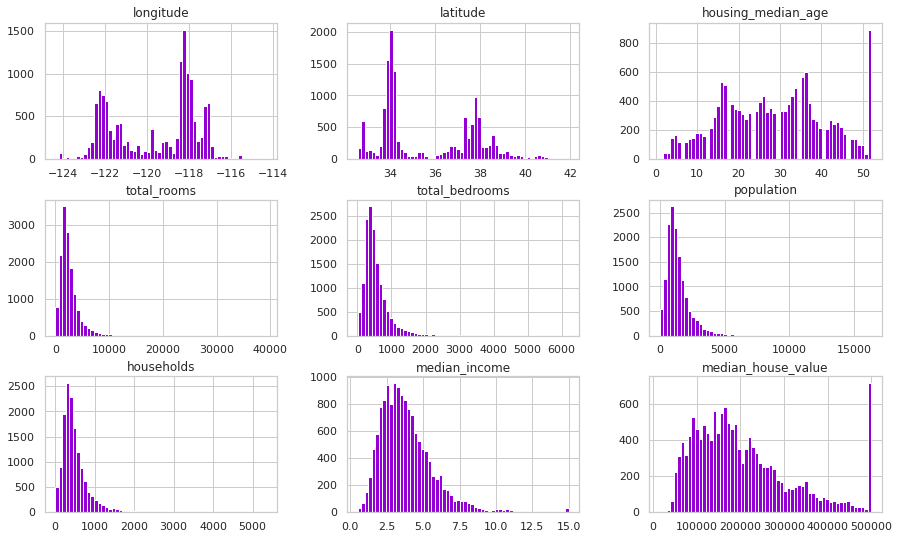

In [13]:
trdata.hist(bins=60, figsize=(15,9),color=color1);plt.show()

#### **Odd Patterns & Outliers**
Data distributions which slightly sticks out:
- On first impression, a few outlier (inconsistent with entire set) groups are present in our data; possibly due to the way in which the data was sampled ( 'housing_median_age' & 'median_house_value' )
- `House_median_age` is one possible feature with such outliers.  Also having a lot of local peaks (all are quite gradual) but one really odd peak at the maximum value stands out. It has some slight discontinuity in data (which becomes visible with the adjustment of bins)
- Feature `Median_house_value` has an odd peak at its maximum value (around 500k), which could be an outlier.

#### **Less Noticeable Outliers**
- We have quite a few skewed (less centralised) data distributions, 6 features have such distributions, which is quite a lot and slightly concerning since we are going to use a relatively simple model. 
- The range of the x axis for some of these features is quite broad (eg. `population`), indicating we have quite a few outliers, but unlike the first two, we can apply `transformation` to features and attempt to correct it.
- Population, total_bedrooms and total_rooms represent somewhat connected things, also have similar distribution which is skewed t owards smaller values.

<br>

### <b> 3.2 | Bivariate correlation matrix</b>

- Bivariate (Two Feature) Two-Feature relation ; `correlation meature`
- Very fast way to understand something about the dataset.
- Correlation matrix contains only information about the linear similarity of two feature relations

What we might look for:

- Often emphasised that `too highly` or `too lowly correlated` features should be dropped
- Any signs of nonlinearity in the dataset, such as a fair few low linear correlation values
- High correlation values between multiple features could indicate that features may represent similar things

In [14]:
''' Function to plot correlation of features '''
def corrMat(df,id=False):
    
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='plasma',square=False,lw=2,annot=True,cbar=False);plt.show()  

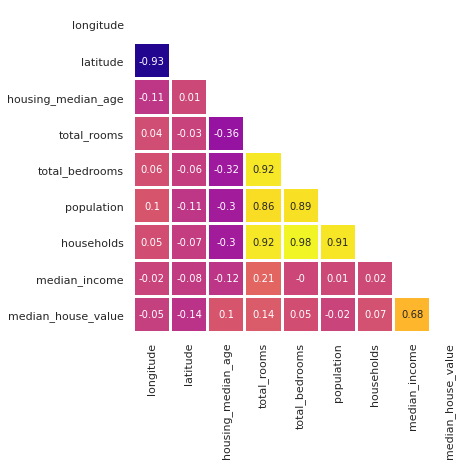

In [15]:
corrMat(trdata) # plot masked numpy correlation matrix

- Target variable `median_house_value` is very mildly correlated to all but one feature here: `median_income`, so one might outline this as an important feature.
- A correlation of -0.02 & -0.05 (`population`/`longitude`) to the target variable `median_house_value` might be worth dropping, but they might not be. In fact, a low value isn't exactly a reason to drop a feature. It could simply imply the data is spread quite a lot, which is a strong indicator of nonlinearity. 
- It is often advised to drop such features, especially for less complex models, as the model probably won't be able to pick up on one feature with such nonlinearity, let alone multiple.
- It's possible to plot a shifted matrix, which looks a little nicer, [code can be found here](https://www.kaggle.com/shtrausslearning/heart-disease-gaussian-process-ensemble)

<br>

### <b> 3.3 | Bivariate scattered data</b>


- Pairplots/Scatter Matrices are very insightful & can be used to find interesting scatter platterns in `bivariate` (two feature data plots) relations
- Scatter plots allow the addition of `color` labelling, however its often quite difficult to distinguish between `color` labels in a scattered matrix

What we might look for:
    
- Irregular two feature patterns or outliers ( multiple features give a clearer picture of outlier )
- Two dimensional Data clusters (using KDE approximation)
- Two feature linear correlation value visualisation in two dimensional space ( is the data sorted linearly or completly random )

In [16]:
''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()

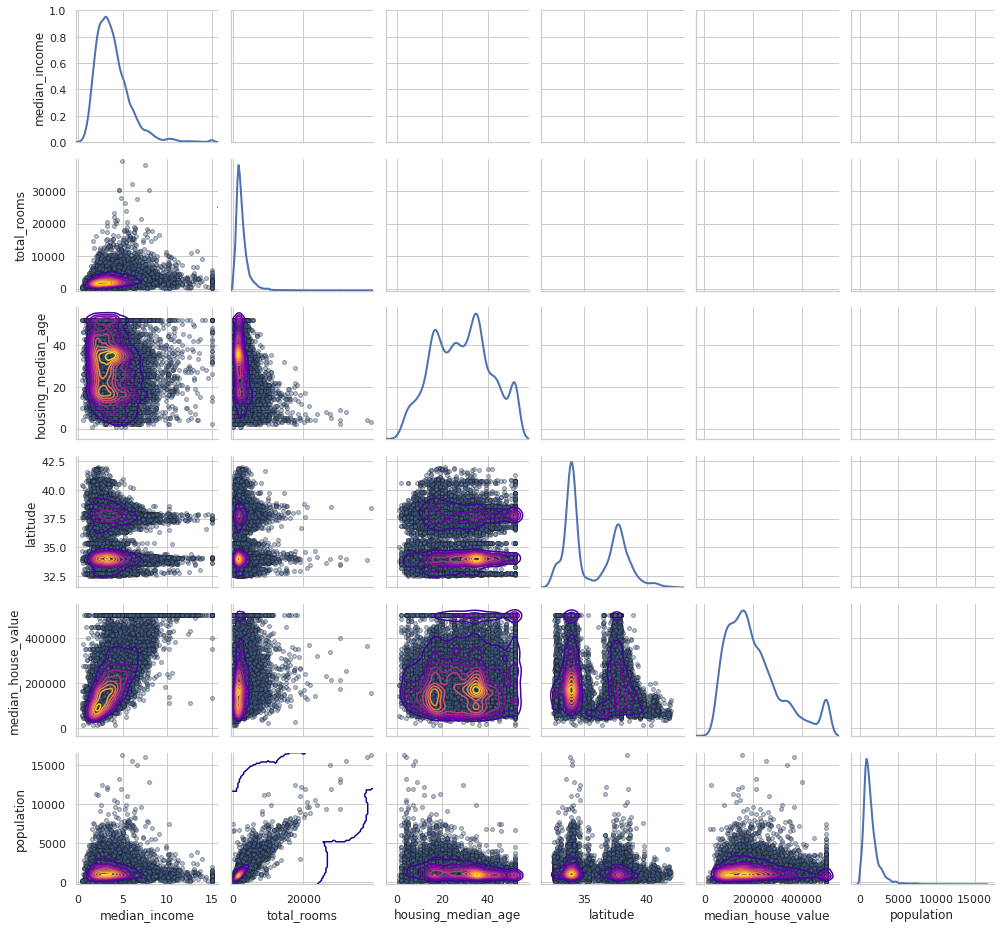

In [17]:
# Seaborn get a little slow, let's plot some interesting features
tlist = ['median_income','total_rooms','housing_median_age','latitude','median_house_value','population']
snsPairGrid(trdata[tlist]) 

#### **Relating to "Median_House_Value"**

- `median_house_value` and `median_income` relation looks quite linear, with a fair bit of deviation normal to the linear line, we can also note a visible upper limit for all values of 'median_income', which in two dimensions, definitely looks out of place.
- In `median_house_age` vs `median_house_value` relation, it looks like the data is completely spread out all over the place; KDE helping the identification of two peaks roughtly 20 years appart, perhaps these peaks are associated with increasing affordability (given they are concentrated in the lower half)
- We an note an additional peak near the peak values of both features as well. The relation is very nonlinear, being scattered everywhere, having data in almost all parts of the graph.
- `median_house_value` & `total_rooms`,`population` seem like quite complex features to model, KDE suggests it's heavily concentrated at lower values for the two, with a fair bit at larger values & a lot of data outside the main clusters, classifiable as `outliers`.
- Many of our features have quite different axis scales, higher values might be interpreted as more important, so scaling should definitely be considered.

<br>

### <b> 3.4 | Geospatial multivariate data</b>

- `Multivariate` visualisating can be even more insightful than `bivariate`. Adding 'hue'/colour to scattered data gives the data an extra dimension we can interpred provided there is minimal overlap <br>
- Geographic plotting is one form of such visualisation. It would be interesting to understand how geography influences various features. 
- We're dealing with geographical data, so [geopandas](https://geopandas.org/) is quite useful, so is `folium` & plotly
- Other modules you might like to add (mainly for 3D) [k3d](https://github.com/K3D-tools/K3D-jupyter/) and [pyvista](https://github.com/pyvista/pyvista) are awesome for multivariate visualisation too.

In [18]:
''' Plot Two Geopandas Plots Side by Side '''
# defining a simple plot function, input list containing features of names found in dataframe
def plotTwo(df,lst):
    
    # load california from module, common for all plots
    cali = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
    cali = cali.assign(area=cali.geometry.area)
    
    # Create a geopandas geometry feature; input dataframe should contain .longtitude, .latitude
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude,df.latitude))
    proj=gcrs.AlbersEqualArea(central_latitude=37.16611, central_longitude=-119.44944) # related to view

    ii=-1
    fig,ax = plt.subplots(1,2,figsize=(21,6),subplot_kw={'projection': proj})
    for i in lst:

        ii+=1
        tgdf = gdf.sort_values(by=i,ascending=True) 
        gplt.polyplot(cali,projection=proj,ax=ax[ii]) # the module already has california 
        gplt.pointplot(tgdf,ax=ax[ii],hue=i,cmap='plasma',legend=True,alpha=1.0,s=3) # 
        ax[ii].set_title(i)

    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.5)

In [19]:
trdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14448 entries, 11440 to 14148
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14448 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   median_house_value  14448 non-null  float64
dtypes: float64(9)
memory usage: 1.7 MB


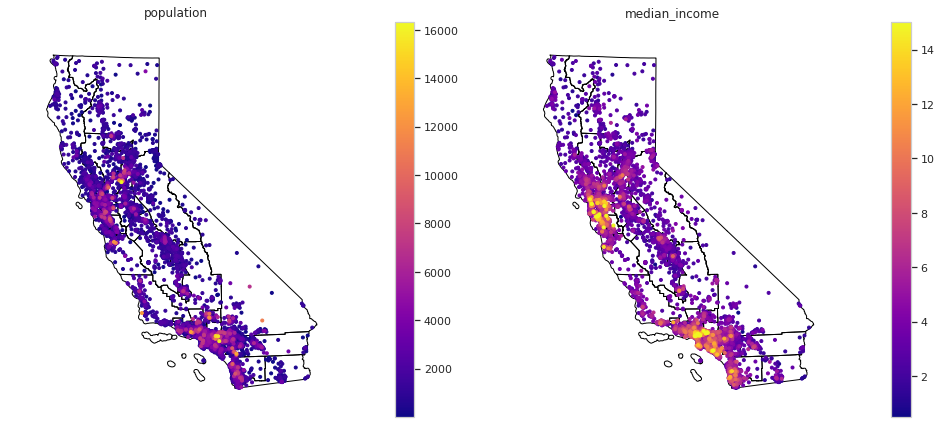

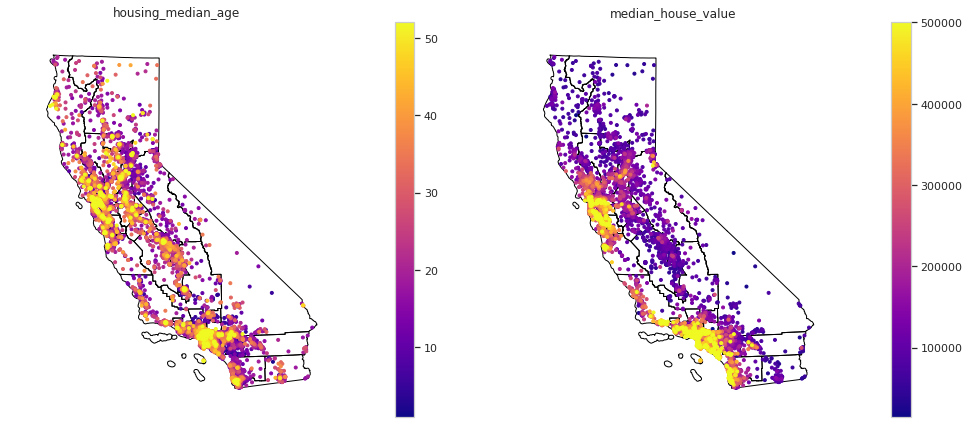

In [20]:
# Call function that plots two geopandas plots 
plotTwo(trdata,['population','median_income'])
plotTwo(trdata,['housing_median_age','median_house_value'])
del trdata['geometry'] # not useful for anything other than gpd visualisation

- For our target variable, `median_house_value`, just by looking at these graphs, one could immediately note some patterns; `geography(location)` and `median_house_income` show clear relation; generally increasing the closer you get to the two main clusters, so these two features would probably be important.

- `Housing_median_age` for a lot of regions is also strongly correlated to the target variable, but in many regions it isn't (slightly more inland), so its not so clear cut. The relation is probably just nonlinear. Recalling the pairplot, we saw quite a lot of spread in the data, however one could notice two main clusters from that graph, which showed some some linearity aspect.

- `Population` is a little more tricky, its somewhat correlated, although we have a few outliers (not even visible on the univariate histogram) which make it harder see a relation as the values are more bunched up in the < 10k group, but there does tend to be a relation though, as indicated by the `correlation` value.

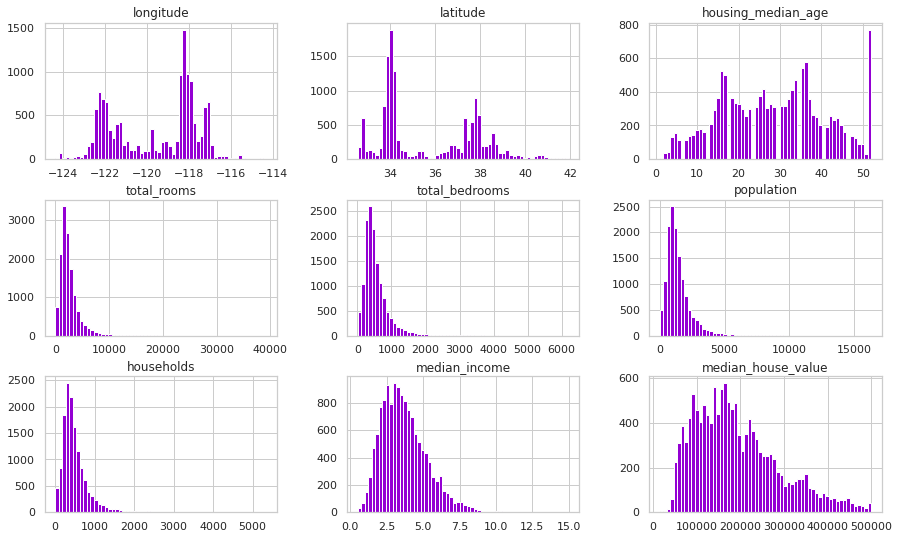

In [21]:
# trdata_upd : training data w/ removed outliers
maxval2 = trdata['median_house_value'].max() # get the maximum value
trdata_upd = trdata[trdata['median_house_value'] != maxval2] 
tedata_upd = tedata[tedata['median_house_value'] != maxval2]
trdata_upd.hist(bins=60, figsize=(15,9),color=color1);plt.show() # looks like its completely removed.

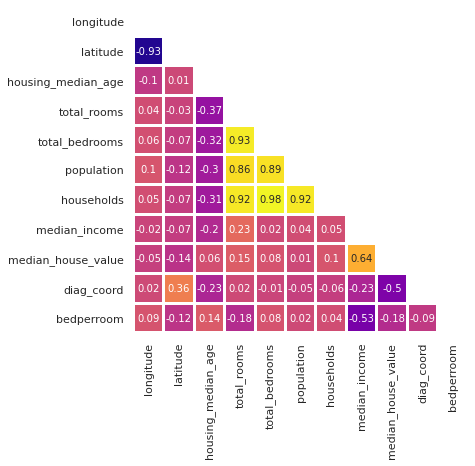

In [22]:
# Make a feature that contains both longtitude & latitude
trdata_upd['diag_coord'] = (trdata_upd['longitude'] + trdata_upd['latitude'])         # 'diagonal coordinate', works for this coord
trdata_upd['bedperroom'] = trdata_upd['total_bedrooms']/trdata_upd['total_rooms']     # feature w/ bedrooms/room ratio
corrMat(trdata_upd)
# update test data as well
tedata_upd['diag_coord'] = (tedata_upd['longitude'] + tedata_upd['latitude'])
tedata_upd['bedperroom'] = tedata_upd['total_bedrooms']/tedata_upd['total_rooms']     # feature w/ bedrooms/room ratio

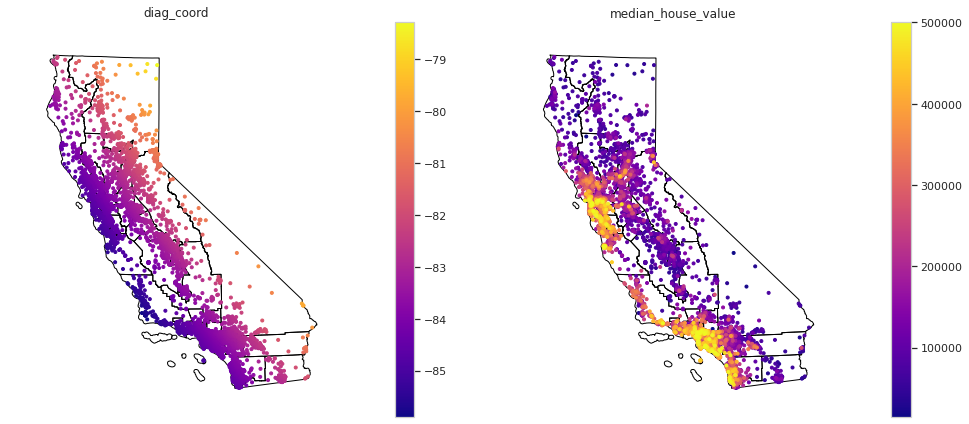

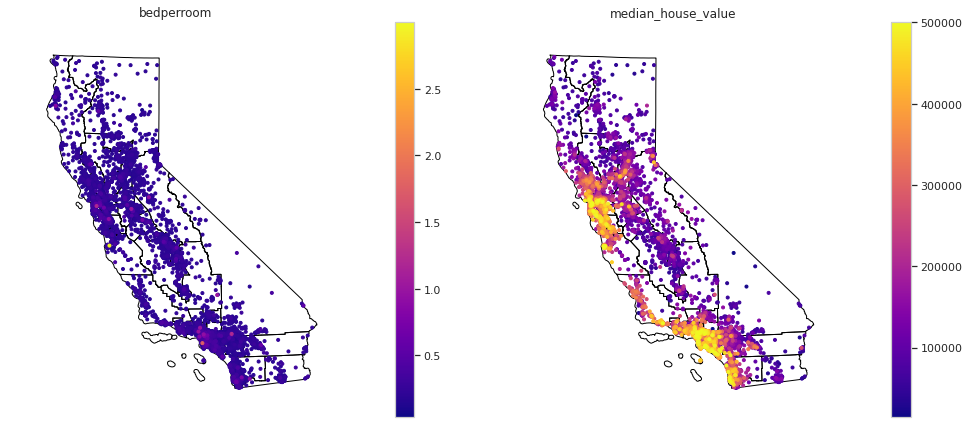

In [23]:
# lets plot them as well
plotTwo(trdata_upd,['diag_coord','median_house_value'])
plotTwo(trdata_upd,['bedperroom','median_house_value'])
del trdata_upd['geometry']  # remove gpd geometry features

- We can note a clear correlation for `diag_coord` & our target variable from the map plot  (inverse correlation)
- On the other hand, `bedperroom` was not not as illuminating as hoped, it's still one of the more highly correlated features though as indicated in the correlation matrix

In [24]:
''' Draw a a single Heatmap using Seaborn '''
def heatmap1(values,xlabel,ylabel,xticklabels,yticklabels,
            cmap='plasma',vmin=None,vmax=None,fmt="%0.2f"):

    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(values, ax=ax,cmap=cmap)
    
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel);ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + 0.5)
    ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    ax.set_title('BR()')
    ax.set_aspect(1)
    
    for p, color, value in zip(img.get_paths(), img.get_facecolors(),img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")

In [28]:
# Model Evaluation w/ Cross Validation
def modelEval(ldf,feature='median_house_value',model_id = 'dummy'):
    
    # Input: Feature & Target DataFrame

    # Split feature/target variable
    y = ldf[feature].copy()
    X = ldf.copy()
    del X[feature]     # remove target variable
    
    # Pick Model 
    if(model_id is 'dummy'):    model = DummyRegressor()
    if(model_id is 'linear'):    model = LinearRegression()
    if(model_id is 'rf'):    model = RandomForestRegressor(n_estimators=10,random_state=10)
    
    ''' Parameter Based Cross Validation (No Pipeline)'''
#     gscv = GridSearchCV(model,param_grid,cv=5)
#     gscv.fit(X,y)
#     results = pd.DataFrame(gscv.cv_results_)
#     scores = np.array(results.mean_test_score).reshape(7,7)
    
#     # plot the cross validation mean scores
#     heatmap1(scores,xlabel='lamda',xticklabels=param_grid['lamd'],
#                     ylabel='alpha',yticklabels=param_grid['alph'])
    
    ''' Standard Cross Validation '''
    cv_score = np.sqrt(-cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error'))
    print("Scores:",cv_score);print("Mean:", cv_score.mean());print("std:", cv_score.std())

In [29]:
# A simple comparison model
modelEval(trdata,model_id='dummy')

Scores: [116663.53235572 114143.42502379 115145.56368682 113864.46156817
 117200.05430992]
Mean: 115403.40738888175
std: 1329.5298616480632


In [30]:
# Original Features
modelEval(trdata,model_id='linear')

Scores: [70473.82220533 69384.88792513 70443.74854606 68844.13546361
 70360.5345124 ]
Mean: 69901.42573050695
std: 665.9139054142352


We can see that the `BR()` Linear Model performs as expected, much better than the baseline model, `DummyRegressor()`, a quick indicator that the model actually learns something meaningful

In [31]:
# Extra Features
modelEval(trdata_upd,model_id='linear')

Scores: [61658.07254216 61903.09037456 62757.75230602 61462.71289446
 61591.65973972]
Mean: 61874.65757138453
std: 464.18961623287805


The addition of two new features (`diag_coord`,`bedperroom`) improved the models performance quite significantly

In [ ]:
# lets remove two of the three similar features
del trdata_upd['total_bedrooms']
del trdata_upd['total_rooms']

In [32]:
modelEval(trdata_upd,model_id='linear')

Scores: [61658.07254216 61903.09037456 62757.75230602 61462.71289446
 61591.65973972]
Mean: 61874.65757138453
std: 464.18961623287805


- We can note that by removing a large portion of the very highly correlated features, there is minimal impact on the models performance, indicating that the two features teach the model very similar things to `population` & are not needed.
- The only benefit we gain is a reduction in training code, withe a reduction of features

<br>

### <b>7.2 | ML pipeline model</b>

`Pipelines` are a very neat way to group multiple steps of a model's preparation process, from `feature matrix` adjustment to the actual model evaluation step. `Pipelines` are also used to prevent `data leakage`.

Let's try two things using `Pipelines`:

- We noted that our data exhibits nonlinear feature relations, so we'll create a simple pipeline that uses `PolynomialFeatures()` and see if that helps the model adjust to the nonlinear nature of a lot of our data (we'll look at 2nd & 3rd order features)
- We also noted that our features have very different ranges for values, which could be an issue. Certain models don't perform very well unless all features have similar scaling, so let's see if `BR()` is one of those models.

In [33]:
''' Plot Two Seaborn Heatmaps Side by Side '''
# used for Polynomial vs non polynomial cross validaion score comparison
def heatmap2(values,values2,xlabel,ylabel,xticklabels,yticklabels,
			cmap='plasma',vmin=None,vmax=None,fmt="%0.2f"):

	fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
	sns.heatmap(values, ax=ax1,cmap=cmap)
	sns.heatmap(values2, ax=ax2,cmap=cmap)
	
	img = ax1.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
	img.update_scalarmappable()
	ax1.set_xlabel(xlabel);ax1.set_ylabel(ylabel)
	ax1.set_xticks(np.arange(len(xticklabels)) + 0.5)
	ax1.set_yticks(np.arange(len(yticklabels)) + 0.5)
	ax1.set_xticklabels(xticklabels);ax1.set_yticklabels(yticklabels)
	ax1.set_title('PolynomialFeatures(2) + BR()')
	ax1.set_aspect(1)
	
	for p, color, value in zip(img.get_paths(), img.get_facecolors(),img.get_array()):
		x, y = p.vertices[:-2, :].mean(0)
		if np.mean(color[:3]) > 0.5:
			c = 'k'
		else:
			c = 'w'
		ax1.text(x, y, fmt % value, color=c, ha="center", va="center")
		
	img = ax2.pcolor(values2, cmap=cmap, vmin=vmin, vmax=vmax)
	img.update_scalarmappable()
	ax2.set_xlabel(xlabel);ax2.set_ylabel(ylabel)
	ax2.set_xticks(np.arange(len(xticklabels)) + 0.5)
	ax2.set_yticks(np.arange(len(yticklabels)) + 0.5)
	ax2.set_xticklabels(xticklabels);ax2.set_yticklabels(yticklabels)
	ax2.set_title('PolynomialFeatures(3) + BR()')
	ax2.set_aspect(1)
	
	for p, color, value in zip(img.get_paths(), img.get_facecolors(),img.get_array()):
		x, y = p.vertices[:-2, :].mean(0)
		if np.mean(color[:3]) > 0.5:
			c = 'k'
		else:
			c = 'w'
		ax2.text(x, y, fmt % value, color=c, ha="center", va="center")

In [36]:
# Model Evaluation Function w/ Pipelines
def modelEval2(ldf,feature='median_house_value',model_id = 'dummy',scaling_id=False):

    # Given a dataframe, split feature/target variable
    y = ldf[feature].copy()
    X = ldf.copy()
    del X[feature]     # remove target variable
    
    tlst = []
    for i in [2,3]:
        
        # Pick Model 
        if(model_id is 'dummy'):    model = DummyRegressor()
        if(model_id is 'linear'):    model = LinearRegression()
        if(model_id is 'rf'):    model = RandomForestRegressor(n_estimators=10,random_state=10)

        # Pick a Pipeline (Polynomial Feature Adjustment + Model)
        if(scaling_id is False):
            pipe = Pipeline(steps=[('poly',PolynomialFeatures(i)),
                                   ('model',model)])
        else:
            pipe = Pipeline(steps=[('scaler',StandardScaler()),
                                   ('poly',PolynomialFeatures(i)),
                                   ('model',model)])

        ''' Parameter Based Cross Validation (With Pipeline)'''
        # define a parameter search grid, pipepines require slightly different notations w/ __
#         param_grid = {
#         'model__lamd': [0.0001,0.001, 0.01, 0.1, 1, 10, 100],
#         'model__alph': [0.0001,0.001, 0.01, 0.1, 1, 10, 100]}
        
#         gscv2 = GridSearchCV(pipe, param_grid,cv=5)
#         gscv2.fit(X,y)
#         ypred = gscv2.predict(X)
#         results2 = pd.DataFrame(gscv2.cv_results_)
#         scores2 = np.array(results2.mean_test_score).reshape(7,7)
#         tlst.append(scores2)
        
        ''' Standard Cross Validation '''
        cv_score = np.sqrt(-cross_val_score(pipe,X,y,cv=5,scoring='neg_mean_squared_error'))
        print("Scores:",cv_score.round(2))
        print("Mean:", cv_score.mean().round(2));print("std:", cv_score.std().round(2))
    
#     plot mean of 5 cross validation segment score
#     heatmap2(tlst[0],tlst[1],xlabel='lamd', xticklabels=param_grid['model__lamd'],
#                              ylabel='alph', yticklabels=param_grid['model__alph'])

In [37]:
modelEval2(trdata_upd,model_id='linear',scaling_id=False)

Scores: [56462.63 56671.54 60371.24 55752.52 56477.21]
Mean: 57147.03
std: 1642.16
Scores: [ 58336.02  75889.76 224317.79  54913.4   71300.47]
Mean: 96951.49
std: 64159.34


- Well, that didn't quite go to plan & we obtain very high error models. The likely cause being the imbalance of feature scaling. 
- Let's actually confirm if `scaling` can fix this issue:

In [38]:
modelEval2(trdata_upd,model_id='linear',scaling_id=True)

Scores: [56462.24 56680.61 59979.36 55757.75 56673.87]
Mean: 57110.77
std: 1473.5
Scores: [ 62418.45  74345.33 179645.61  54898.71  90975.37]
Mean: 92456.69
std: 45265.93


- It's interesting to note that we have quite a significant improvement in accuracy with the addition of 2nd order features, however 3rd order features gave us a worse result.
- With the addition of `PolynomialFeatures()`, this is quite a common occurence. It's likely we can get an improvement if we increase the order even further, however there are slight issue with such an approach. 
- To utilise polynomial features more effectively, one has to carefully manage the number of features that are fed into the model & reduce them as much as possible. There tends to be a limit at which the the cost of matrix inversion becomes a little too much, at which it would probably be best to use something more efficient, like Gaussian Process Regression `GP()` to adapt to more complex data spread in higher dimensions without `PolynomialFeatures()`
- The class `BR()` already utilises pseudoinversion, `pinv()` as opposed to standard matrix inversion, without which 3rd order will probably give us a singular matrix condition; indicating the model is has a clear restriction relating to the feature number (you can easily confirm this)
<br>
***
- Let's quicky check how our model performs to a very common & powerful `ensemble` model, `RandomForest()`:

In [39]:
modelEval(trdata_upd,model_id='rf')

Scores: [47736.78249499 48708.78067893 49183.18985328 47719.42426361
 48483.59500154]
Mean: 48366.354458470094
std: 567.9965946783395


- We can see that even a very powerful like `RandomForest()` can't really reduce the `RMSE` with the current set of feature & instance combination very much further (despite being a model that very easily can overpredict) 
- An error of 48,000 is quite a large in the context of the target values & it's probably a reasonable idea to investigate the validity of the current dataset & review it
- The dataset is quite old & doesn't contain the best features comapared to more recent datasets, like the introductory [House Price Problem](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) ( which was quite fun! ), but hopefully the basic approach one can take was clear.